Importing

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = "D:\\College_Semesters\\6th Semester\\C. Deep Learning for Signal & Image Processing\\Project_New\\Dataset"
SEED = 40
os.listdir(MAIN_DIR)

['ai',
 'cha',
 'ee',
 'ka',
 'la',
 'ma',
 'moo',
 'nna',
 'nnna',
 'nu',
 'nuu',
 'oo',
 'pa',
 'ra',
 'tha',
 'va',
 'vee',
 'vu',
 'y',
 'ya',
 'zha']

In [3]:
def load_images(folder):
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                if img.shape[-1] == 1:
                    # convert grayscale image to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                img = cv2.resize(img,(224,224))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1
    
    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [4]:
data, labels = load_images(MAIN_DIR)

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

y_one_hot = to_categorical(y, num_classes=21) # One-hot encode the target variable

norm_data = data / 255. 
norm_data.shape, norm_data[0]

((2698, 224, 224, 3),
 array([[[0.16470588, 0.32941176, 0.49411765],
         [0.16470588, 0.32941176, 0.49411765],
         [0.16470588, 0.32941176, 0.49411765],
         ...,
         [0.15294118, 0.32156863, 0.49019608],
         [0.14509804, 0.32156863, 0.49019608],
         [0.14509804, 0.32156863, 0.49019608]],
 
        [[0.16470588, 0.32941176, 0.49411765],
         [0.16470588, 0.32941176, 0.49411765],
         [0.16470588, 0.32941176, 0.49411765],
         ...,
         [0.15294118, 0.32156863, 0.49019608],
         [0.14509804, 0.32156863, 0.49019608],
         [0.14509804, 0.32156863, 0.49019608]],
 
        [[0.16470588, 0.32941176, 0.49411765],
         [0.16470588, 0.32941176, 0.49411765],
         [0.16470588, 0.32941176, 0.49411765],
         ...,
         [0.15294118, 0.32156863, 0.49019608],
         [0.15294118, 0.32156863, 0.49019608],
         [0.15294118, 0.32156863, 0.49019608]],
 
        ...,
 
        [[0.15294118, 0.3372549 , 0.4627451 ],
         [0.1529411

In [6]:
# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print("Train Data Shape:", train_data.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

Train Data Shape: (2158, 224, 224, 3)
Train Labels Shape: (2158,)
Test Data Shape: (540, 224, 224, 3)
Test Labels Shape: (540,)


In [7]:
from tensorflow.keras.utils import to_categorical

# Convert target labels to one-hot encoded format
train_labels = to_categorical(train_labels, num_classes=21)
test_labels = to_categorical(test_labels, num_classes=21)

# train_data = train_data.reshape[1:]
# test_data = test_data.reshape[1:]

In [8]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Conv2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.optimizers import Adam
from lime import lime_image
from skimage.segmentation import slic
import numpy as np

# Define the DenseNet model
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(growth_rate, kernel_size=(3, 3), padding='same')(x1)
        x = Concatenate()([x, x1])
    return x

def transition_block(x, compression_factor):
    num_filters = int(x.shape[-1])
    num_filters = int(num_filters * compression_factor)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=(1, 1))(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    return x

def DenseNet(input_shape, num_classes, num_blocks, num_layers, growth_rate, compression_factor):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    for i in range(num_blocks - 1):
        x = dense_block(x, num_layers, growth_rate)
        x = transition_block(x, compression_factor)
    
    x = dense_block(x, num_layers, growth_rate)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Set the hyperparameters
input_shape = norm_data.shape[1:]
num_classes = 21
num_blocks = 4  # Number of dense blocks
num_layers = 4  # Number of layers in each dense block
growth_rate = 32  # Number of filters in each layer within a dense block
compression_factor = 0.5  # Compression factor for transition blocks

# Create the DenseNet model
model = DenseNet(input_shape, num_classes, num_blocks, num_layers, growth_rate, compression_factor)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
history = model.fit(train_data, train_labels, epochs=50, batch_size=32, validation_data=(test_data, test_labels))

# LIME
# LIME
explainer = lime_image.LimeImageExplainer()

# Preprocess the image
image_to_explain = norm_data[0] * 255  # Choose the first image from the dataset and convert to original scale

explanation = explainer.explain_instance(image_to_explain, model.predict, top_labels=21, num_samples=1000, segmentation_fn=slic)

lime_image, mask = explanation.get_image_and_mask(0, positive_only=False, hide_rest=False)

Epoch 1/50
68/68 [==============================] - 207s 3s/step - loss: 1.8093 - accuracy: 0.4778 - val_loss: 4.8844 - val_accuracy: 0.0426
Epoch 2/50
68/68 [==============================] - 190s 3s/step - loss: 0.8008 - accuracy: 0.8184 - val_loss: 3.6430 - val_accuracy: 0.1537
Epoch 3/50
68/68 [==============================] - 186s 3s/step - loss: 0.4621 - accuracy: 0.8967 - val_loss: 4.2171 - val_accuracy: 0.1296
Epoch 4/50
68/68 [==============================] - 183s 3s/step - loss: 0.3374 - accuracy: 0.9268 - val_loss: 1.8211 - val_accuracy: 0.4481
Epoch 5/50
68/68 [==============================] - 178s 3s/step - loss: 0.2396 - accuracy: 0.9411 - val_loss: 0.6441 - val_accuracy: 0.7944
Epoch 6/50
68/68 [==============================] - 179s 3s/step - loss: 0.1666 - accuracy: 0.9666 - val_loss: 0.5684 - val_accuracy: 0.8370
Epoch 7/50
68/68 [==============================] - 170s 3s/step - loss: 0.1406 - accuracy: 0.9708 - val_loss: 0.4193 - val_accuracy: 0.8648
Epoch 8/50
68

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 178ms/step
Explanation not available for Class 0. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 188ms/step
Explanation not available for Class 1. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 202ms/step
Explanation not available for Class 2. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 220ms/step
Explanation not available for Class 3. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 206ms/step
Explanation not available for Class 4. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 208ms/step
Explanation not available for Class 5. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 338ms/step
Explanation not available for Class 6. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 388ms/step
Explanation not available for Class 7. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 369ms/step
Explanation not available for Class 8. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 348ms/step


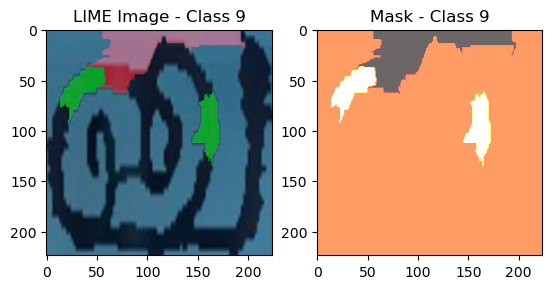

  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 373ms/step
Explanation not available for Class 10. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 365ms/step
Explanation not available for Class 11. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 407ms/step
Explanation not available for Class 12. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 387ms/step
Explanation not available for Class 13. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 367ms/step
Explanation not available for Class 14. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 399ms/step
Explanation not available for Class 15. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 422ms/step
Explanation not available for Class 16. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 436ms/step
Explanation not available for Class 17. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 452ms/step
Explanation not available for Class 18. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 467ms/step
Explanation not available for Class 19. Skipping...


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 478ms/step
Explanation not available for Class 20. Skipping...


In [34]:
import numpy as np
from lime import lime_image
from skimage.segmentation import slic
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt

# Select the image index you want to explain
image_index = 0

# Get the image to explain
image_to_explain = test_data[image_index]

# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define the function to classify the image using your model
def classifier_fn(images):
    return model.predict(images)

# Iterate over each class
for class_index in range(num_classes):
    # Explain the image for the current class using LIME
    try:
        explanation = explainer.explain_instance(image_to_explain, classifier_fn, top_labels=1,
                                                 num_samples=3000, segmentation_fn=quickshift, labels=(class_index,))
        
        # Get the LIME image and mask for the current class
        lime_image, mask = explanation.get_image_and_mask(class_index, positive_only=False, hide_rest=False)
        
        # Change lime image color
        lime_image[np.all(lime_image == [0, 0, 1], axis=-1)] = [0, 0, 0]  # Replace blue color with black
        
        # Visualize LIME and mask images for the current class
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(lime_image)
        plt.title(f"LIME Image - Class {class_index}")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='hot', alpha=0.6)
        plt.title(f"Mask - Class {class_index}")
        plt.show()
        
    except KeyError:
        print(f"Explanation not available for Class {class_index}. Skipping...")

In [35]:
# import matplotlib.pyplot as plt

# # Visualize the Lime Image
# plt.imshow(lime_image, cmap='gray')
# plt.axis('off')
# plt.title('Lime Image')
# plt.show()

# # Visualize the Mask
# plt.imshow(mask, cmap='gray')
# plt.axis('off')
# plt.title('Mask')
# plt.show()

In [14]:
model.save("DenseNet_4.h5")

In [15]:
tf.keras.models.save_model(model,'DenseNet4.hdf5')

In [16]:
# Evaluate the model on the test data
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test Loss:', test_loss)

accuracy = np.mean(predicted_labels == true_labels)
print('Accuracy:', accuracy*100)

17/17 [==============================] - 10s 609ms/step - loss: 0.0814 - accuracy: 0.9778
Test Loss: 0.08136595040559769
Accuracy: 97.77777777777777


In [17]:
from sklearn.metrics import classification_report

# Make predictions on the test data
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Print the classification report
print(classification_report(true_labels, predicted_labels))

17/17 [==============================] - 9s 544ms/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.96      1.00      0.98        23
           2       1.00      0.96      0.98        52
           3       0.95      1.00      0.97        35
           4       0.95      1.00      0.98        21
           5       1.00      1.00      1.00        33
           6       1.00      0.91      0.95        32
           7       1.00      0.93      0.96        28
           8       0.89      1.00      0.94        17
           9       0.90      1.00      0.95        27
          10       1.00      0.96      0.98        28
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        17
          13       1.00      1.00      1.00        20
          14       1.00      0.95      0.98        22
          15       0.96      1.00      0.98        24
          16       1.00   

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

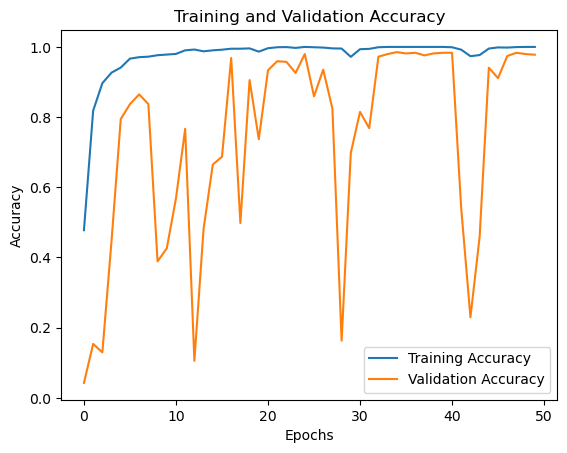

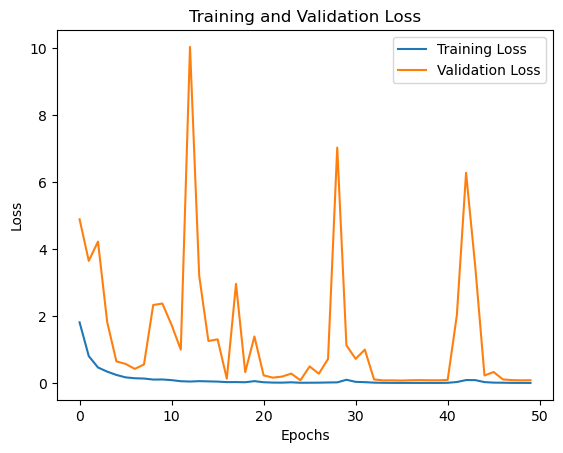

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()